In [166]:
import functools
import importlib
import pickle

import keras
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.metrics
import sklearn.model_selection
import sklearn.multiclass
import sklearn.neural_network
import tqdm

import lapprox.misc.utils as utils
import lapprox.models.ssa as ssa
import lapprox.models.ar as ar
import lapprox.models.arma as arma
import lapprox.models.fft as fft
import lapprox.models.semor as semor
import lapprox.joint.joint_mapping as joint_mapping
import lapprox.segments.normalize as normalize
import lapprox.misc.namespace_cutter as namespace_cutter

importlib.reload(joint_mapping)

%matplotlib inline

In [167]:
with open("data/semor_profiles.pickle", "rb") as f:
    semor_profiles = pickle.load(f)

for key, profile in semor_profiles.items():
    semor_profiles[key] = normalize.shrink_segment(profile, 20)

with open("data/segments.pickle", "rb") as f:
    segments_dict = pickle.load(f) 

## Подготавливаем данные

In [168]:
action_and_segment = []

for key, segments_array in segments_dict.items():
    action_and_segment.extend([(key, s) for s in segments_array if s.size > 30])

segments = [pair[1] for pair in action_and_segment]
actions = [pair[0] for pair in action_and_segment]

In [169]:
normalized_segments = normalize.normalize_segments(segments)
action_and_norm_segment = [(pair[0][0], pair[1])
                           for pair in zip(action_and_segment, normalized_segments)]
le = sklearn.preprocessing.LabelEncoder()
Y = le.fit_transform(actions)
X = np.array(normalized_segments)

In [170]:
models = {
    "ssa_5": ssa.Ssa(5),
    "ssa_10": ssa.Ssa(10),
    "ar_2": ar.Ar(2),
    "ar_4": ar.Ar(4),
#     "arma_2_2": arma.Arma(2, 2),
    "fft_2": fft.Fft(2),
    "fft_5": fft.Fft(5),
    "semor_run": semor.Semor(semor_profiles['run']),
    "semor_walk": semor.Semor(semor_profiles['walk']),
    "semor_up": semor.Semor(semor_profiles['up']),
    "semor_down": semor.Semor(semor_profiles['down'])
}
mapper = joint_mapping.JointMapping(models)
X_intermediate = mapper.fit_transform(X)

In [171]:
def grid_search_using_mapping(X_intermediate, Y, mapper, clf, clf_grid, cv=10, n_jobs=-1):
    cutter = namespace_cutter.CutNamespacesTransformer(namespaces=[], mapping=mapper)

    pipeline = sklearn.pipeline.Pipeline([
        ('namespace_cutter', cutter),
        ('clf', clf)
    ])
    grid = dict({'namespace_cutter__namespaces': utils.all_combinations(list(models))}, **clf_grid)
    gs = sklearn.model_selection.GridSearchCV(pipeline, grid, scoring='neg_log_loss', cv=cv, n_jobs=n_jobs, verbose=1,
                                              return_train_score=True)
    gs.fit(X_intermediate, Y)
    return gs

gss_clojure = functools.partial(grid_search_using_mapping, X_intermediate, Y, mapper)

grids = {}
clfs = {}
grid_search_results = {}

# Logistic regression, l2-regularization.
# clfs['lr_l2'] = sklearn.linear_model.LogisticRegressionCV(multi_class='multinomial',
#                                                           scoring='neg_log_loss')
clfs['lr_l2'] = sklearn.linear_model.LogisticRegression(penalty='l2')
grids['lr_l2'] = {}
# Logistic regression, l1-regularization.
clfs['lr_l1'] = sklearn.linear_model.LogisticRegression(solver='liblinear', penalty='l1')
grids['lr_l1'] = {}

# Elastic-net
# clfs['en'] = sklearn.linear_model.ElasticNetCV()
# grids['en'] = {}

In [172]:
# gss_clojure(clfs['en'], grids['en'], n_jobs=1)

In [173]:
grid_search_results['lr_l2'] = gss_clojure(clfs['lr_l2'], grids['lr_l2'], n_jobs=-1)
grid_search_results['lr_l1'] = gss_clojure(clfs['lr_l1'], grids['lr_l1'], n_jobs=-1)

Fitting 10 folds for each of 1022 candidates, totalling 10220 fits


[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1488 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3488 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 8104 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 10220 out of 10220 | elapsed:   45.8s finished


Fitting 10 folds for each of 1022 candidates, totalling 10220 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2020 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 4243 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 6823 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9025 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 10220 out of 10220 | elapsed:  2.5min finished


In [136]:
grid_search_results['lr_l2'].best_score_

-0.18931783408059386

# Нейронная сеть

In [157]:
def transform_to_inputs(Y, n_classes):
    Y_binary = np.zeros((Y.shape[0], n_classes))
    for i in range(n_classes):
        Y_binary[:, i] = (Y == i)
    
    return Y_binary

def test_neural_network(X, Y, units, cv=10):
    n_classes = len(set(Y))
    kfold = sklearn.model_selection.StratifiedKFold(n_splits=cv, random_state=1)
    
    scores = []
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = (keras.utils.np_utils.to_categorical(Y[train_index], n_classes),
                           keras.utils.np_utils.to_categorical(Y[test_index], n_classes))
        model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(units, ), activation='logistic')
        
#         model = keras.models.Sequential()
#         model.add(keras.layers.Dense(units, activation='relu', input_dim=X_train.shape[1]))
#         model.add(keras.layers.Dense(n_classes, activation='sigmoid'))
#         model.compile(loss='categorical_crossentropy',
#                       optimizer='rmsprop')
        model.fit(X_train, Y[train_index])
        y_pred = model.predict_proba(X_test)
        scores.append(sklearn.metrics.log_loss(Y[test_index], y_pred))
#         scores.append(model.evaluate(X_test, y_test, verbose=0)
    
    return np.array(scores)

In [158]:
scores = []

for units in tqdm.tqdm(np.logspace(1, 3, num=20)):
    scores.append((int(units), np.array(test_neural_network(X, Y, int(units)))))

  0%|          | 0/20 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_netwo

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
 15%|█▌        | 3/20 [00:03<00:17,  1.03s/it]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neur

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: Conve

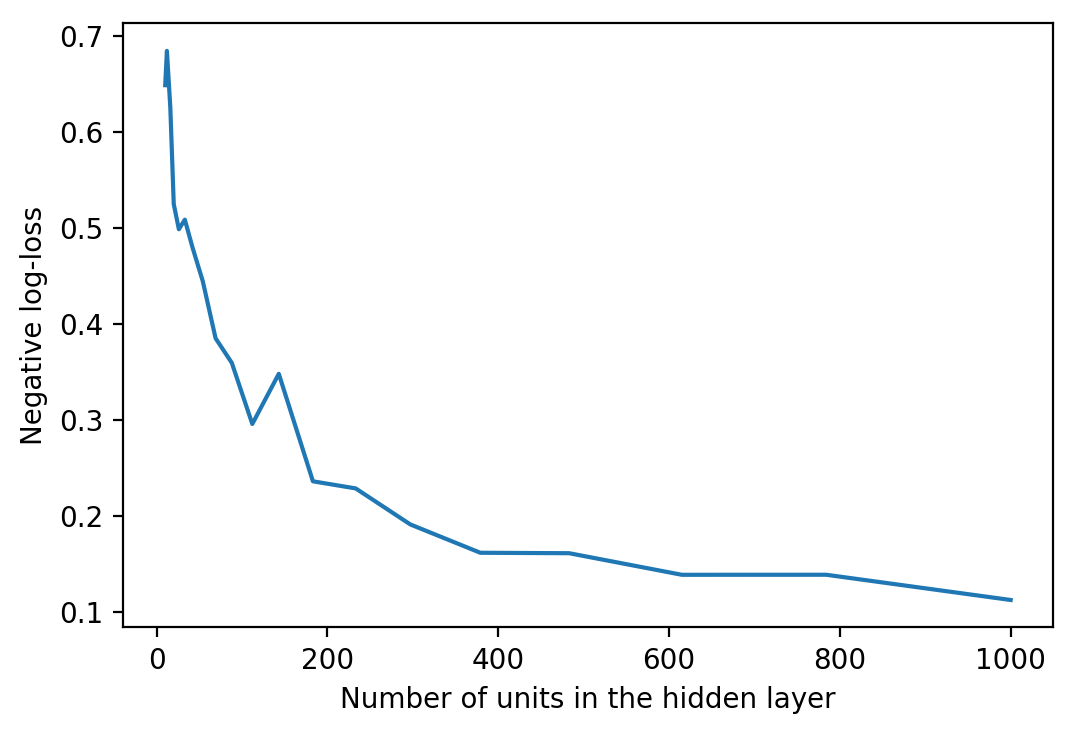

In [162]:
plt.figure(dpi=200)
plt.errorbar(x=[p[0] for p in scores], y=[np.min(p[1]) for p in scores])
plt.xlabel("Number of units in the hidden layer")
plt.ylabel("Negative log-loss")
plt.savefig("../pics/loss_of_n_units.png")

In [164]:
# with open("data/nn_scores_plot.pickle", "wb") as f:
#     pickle.dump(scores, f)

## Логистическая регрессия на всех признаках

In [65]:
grid = {
    'C': 10 ** np.linspace(-3, 4, 40)
}
clf = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear')
gs = sklearn.model_selection.GridSearchCV(clf, grid, scoring='neg_log_loss', cv=10, n_jobs=-1, verbose=1,
                                          return_train_score=True`)
gs.fit(X_intermediate, Y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    7.4s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.51178e-03, 2.28546e-03, 3.45511e-03, 5.22335e-03,
       7.89652e-03, 1.19378e-02, 1.80472e-02, 2.72833e-02, 4.12463e-02,
       6.23551e-02, 9.42668e-02, 1.42510e-01, 2.15443e-01, 3.25702e-01,
       4.92388e-01, 7.44380e-01, 1.12534e+00, 1.70125e+00, 2.57191e... 8.37678e+02, 1.26638e+03,
       1.91448e+03, 2.89427e+03, 4.37548e+03, 6.61474e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=1)

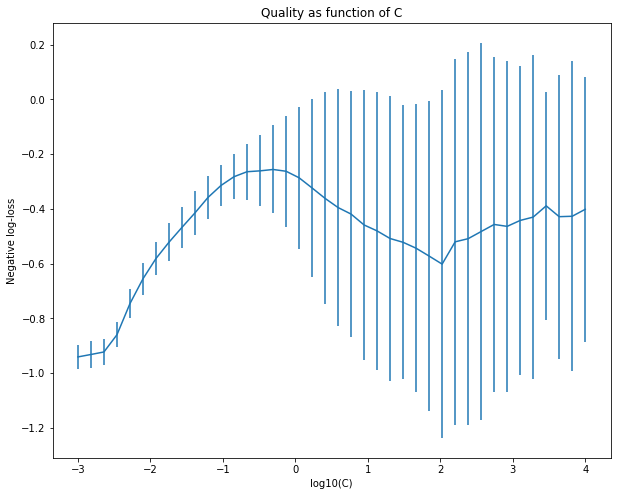

In [91]:
plt.figure(figsize=(10, 8))
c_grid = gs.param_grid['C']
plt.errorbar(np.log10(c_grid), gs.cv_results_['mean_test_score'], gs.cv_results_['std_test_score'])
plt.xlabel('log10(C)')
plt.ylabel('Negative log-loss')
plt.title("Quality as function of C")
plt.savefig("../pics/lr_quality_C.png", dpi=200)

In [87]:
C_to_feature_count = []

for C in grid['C']:
    clf = sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear', C=C)
    clf.fit(X_intermediate, Y)
    C_to_feature_count.append((C, np.sum(np.isclose(clf.coef_, 0.0))))

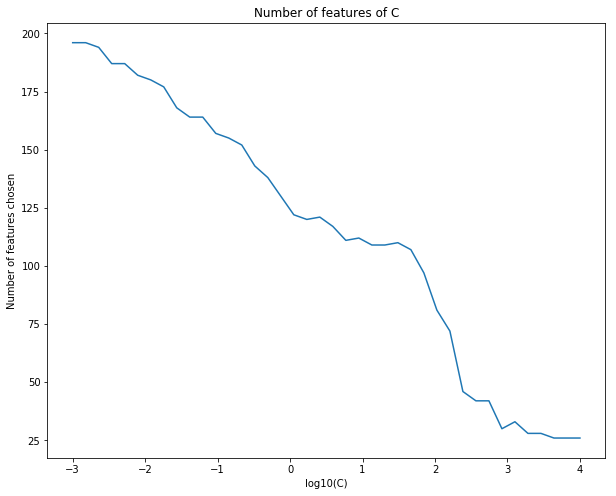

In [92]:
plt.figure(figsize=(10, 8))
plt.plot(np.log10([t[0] for t in C_to_feature_count]), [t[1] for t in C_to_feature_count])
plt.xlabel('log10(C)')
plt.ylabel('Number of features chosen')
plt.title("Number of features of C")
plt.savefig("../pics/lr_n_features_C.png", dpi=200)

# Графики

## Модель с промежуточным пространством

In [34]:
grid_search_results['lr_l2'].best_score_

-0.1895112268157099

## Качество на нейронке

In [22]:
score_tuples = [(k, v) for k, v in scores.items()]
score_tuples = sorted(score_tuples, key = lambda x: x[0])
X = np.array([t[0] for t in score_tuples])
score_arrays = np.array([t[1] for t in score_tuples])

Text(0,0.5,'Negative log-loss')

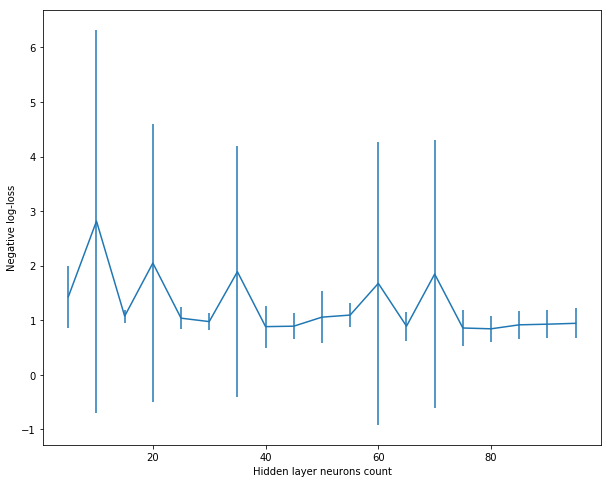

In [30]:
plt.figure(figsize=(10, 8))
plt.errorbar(X, np.mean(score_arrays, axis=1), yerr=np.std(score_arrays, axis=1))
plt.xlabel("Hidden layer neurons count")
plt.ylabel("Negative log-loss")